<a href="https://colab.research.google.com/github/arsalanmontazeri/Arsalan-Montazeri/blob/main/spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For displaying all of the columns in dataframes
pd.set_option('display.max_column',None)
# For data modeling
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
# For saving models
import pickle

In [51]:
spotify=pd.read_csv('spotify_data.csv')

In [52]:
spotify.head()

,Songs & Artist,Streams,Daily
0,The Weeknd - Blinding Lights,4463658617,1619447.0
1,Ed Sheeran - Shape of You,4018102402,1001507.0
2,Lewis Capaldi - Someone You Loved,3588673578,1506961.0
3,Harry Styles - As It Was,3544187311,1611374.0
4,Post Malone - Sunflower,3518744128,1337404.0


In [53]:
spotify.shape

(2500, 3)

In [54]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Songs & Artist  2500 non-null   object 
 1   Streams         2500 non-null   int64  
 2   Daily           2498 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 58.7+ KB


In [55]:
spotify.isna().sum()

,0
Songs & Artist,0
Streams,0
Daily,2


In [56]:
missing_row=spotify[spotify.isnull().any(axis=1)]
missing_row

,Songs & Artist,Streams,Daily
398,Ed Sheeran - Shivers,1356315091,NaN
1795,Lil Tjay - F.N,624709072,NaN


In [57]:
df=spotify.dropna()

In [58]:
split = df['Songs & Artist'].str.split(' - ', expand=True,n=1)
if split.shape[1]==2:
  df[['Artist','Song']]=split
else:
  df['Artist']=split[0]
  df['Song']=split[1] if split.shape[1] > 1 else None

<ipython-input-58-71dac9370d9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Artist','Song']]=split
<ipython-input-58-71dac9370d9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Artist','Song']]=split


In [59]:
df.drop('Songs & Artist',axis=1,inplace=True)



<ipython-input-59-807f922e02b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Songs & Artist',axis=1,inplace=True)


In [60]:
df.head()

,Streams,Daily,Artist,Song
0,4463658617,1619447.0,The Weeknd,Blinding Lights
1,4018102402,1001507.0,Ed Sheeran,Shape of You
2,3588673578,1506961.0,Lewis Capaldi,Someone You Loved
3,3544187311,1611374.0,Harry Styles,As It Was
4,3518744128,1337404.0,Post Malone,Sunflower


In [61]:
df.describe()

,Streams,Daily
count,2.498000e+03,2.498000e+03
mean,9.381018e+08,5.044663e+05
std,4.789547e+08,4.963328e+05
min,5.052491e+08,7.523000e+03
25%,6.097427e+08,2.245135e+05
50%,7.628053e+08,3.763570e+05
75%,1.096359e+09,6.318060e+05
max,4.463659e+09,7.553534e+06


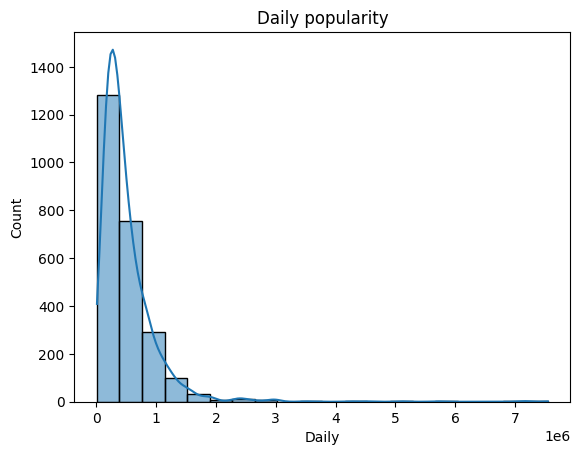

In [62]:
sns.histplot(df['Daily'],bins=20,kde=True)
plt.title('Daily popularity')
plt.show()

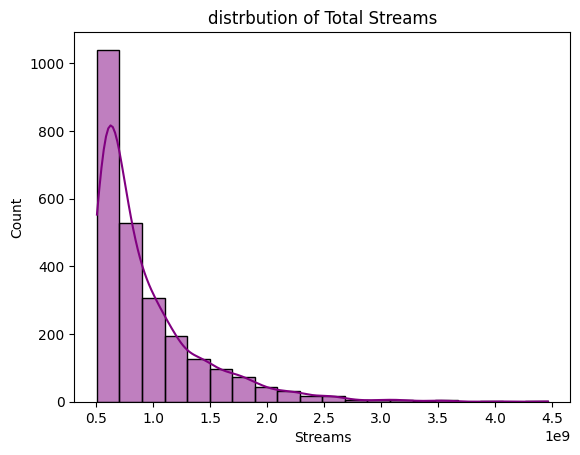

In [63]:
sns.histplot(df['Streams'],bins=20,kde=True,color='purple')
plt.title('distrbution of Total Streams')
plt.show()

<ipython-input-64-99d153ee842a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artist.values,y=top_artist.index,orient='h',palette='coolwarm')


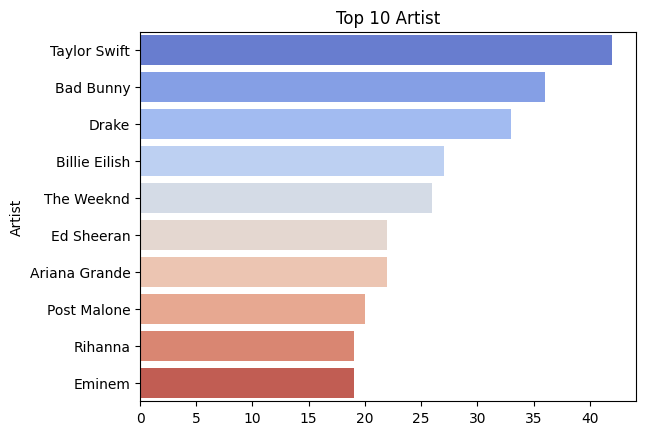

,count
Artist,
Taylor Swift,42
Bad Bunny,36
Drake,33
Billie Eilish,27
The Weeknd,26
Ed Sheeran,22
Ariana Grande,22
Post Malone,20
Rihanna,19


In [64]:
top_artist=df['Artist'].value_counts().head(10)
sns.barplot(x=top_artist.values,y=top_artist.index,orient='h',palette='coolwarm')
plt.title('Top 10 Artist')
plt.show()
top_artist

In [65]:
top_stream=df.groupby(['Artist','Song'])['Streams'].sum().sort_values(ascending=False).head(10)
top_stream

Artist         Song             
The Weeknd     Blinding Lights      4463658617
Ed Sheeran     Shape of You         4018102402
The Weeknd     Save Your Tears      3748288957
Lewis Capaldi  Someone You Loved    3588673578
Harry Styles   As It Was            3544187311
Luis Fonsi     Despacito            3540359291
Post Malone    Sunflower            3518744128
The Weeknd     Starboy              3481137472
               Die For You          3408433281
Drake          One Dance            3343221259
Name: Streams, dtype: int64

                Song             Artist     Streams
0    Blinding Lights         The Weeknd  4463658617
1       Shape of You         Ed Sheeran  4018102402
2  Someone You Loved      Lewis Capaldi  3588673578
3          As It Was       Harry Styles  3544187311
4          Sunflower        Post Malone  3518744128
5            Starboy         The Weeknd  3481137472
6          One Dance              Drake  3343221259
7               STAY      The Kid LAROI  3266446596
8    Sweater Weather  The Neighbourhood  3187169593
9           Believer    Imagine Dragons  3140449933


<ipython-input-66-edd65fa2e075>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_streamed,x='Streams',y='Song',palette='viridis')


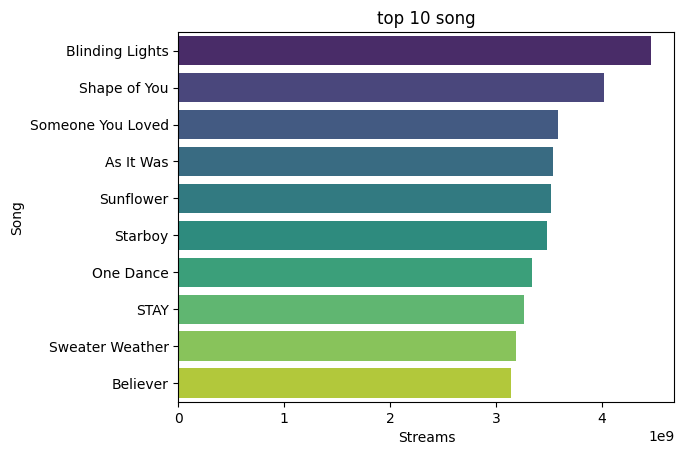

In [66]:
top_streamed = df.sort_values(by='Streams', ascending=False).head(10)
print(top_streamed[['Song', 'Artist', 'Streams']])
sns.barplot(data=top_streamed,x='Streams',y='Song',palette='viridis')
plt.title('top 10 song')
plt.show()

                      Song             Artist      Daily
1911                   Who              Jimin  7553534.0
647     BIRDS OF A FEATHER      Billie Eilish  7194182.0
590           Lose Control        Teddy Swims  7082537.0
418               Espresso  Sabrina Carpenter  5709725.0
1449      Good Luck, Babe!      Chappell Roan  5123739.0
1139  Please Please Please  Sabrina Carpenter  4525181.0
392       Beautiful Things       Benson Boone  4241882.0
1297    A Bar Song (Tipsy)          Shaboozey  3516596.0
850              Too Sweet             Hozier  3011228.0
564              Gata Only         FloyyMenor  2996560.0


<ipython-input-67-fd1681289514>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_daily,x='Daily',y='Song',palette='rocket')


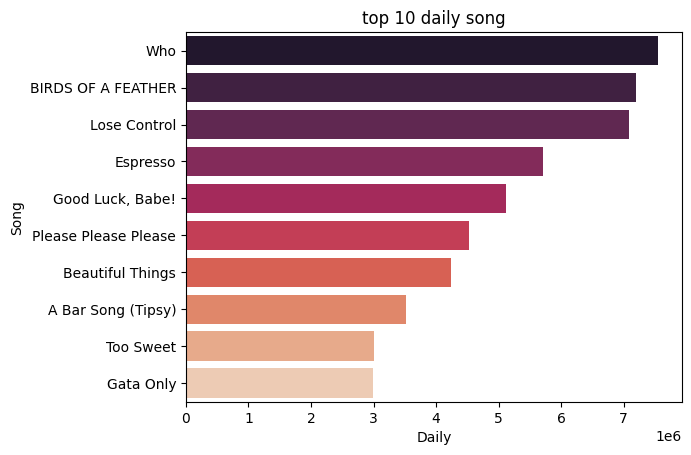

In [67]:
top_daily=df.sort_values(by='Daily',ascending=False).head(10)
print(top_daily[['Song','Artist','Daily']])
sns.barplot(data=top_daily,x='Daily',y='Song',palette='rocket')
plt.title('top 10 daily song')
plt.show()

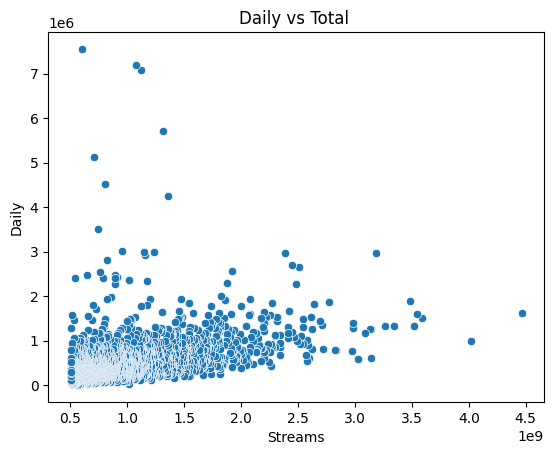

corrolation btweem total and daily streams :0.4432068612642736


In [68]:
sns.scatterplot(data=df,x='Streams',y='Daily')
plt.title('Daily vs Total ')
plt.show()
corrolation=df['Streams'].corr(df['Daily'])
print(f'corrolation btweem total and daily streams :{corrolation}')

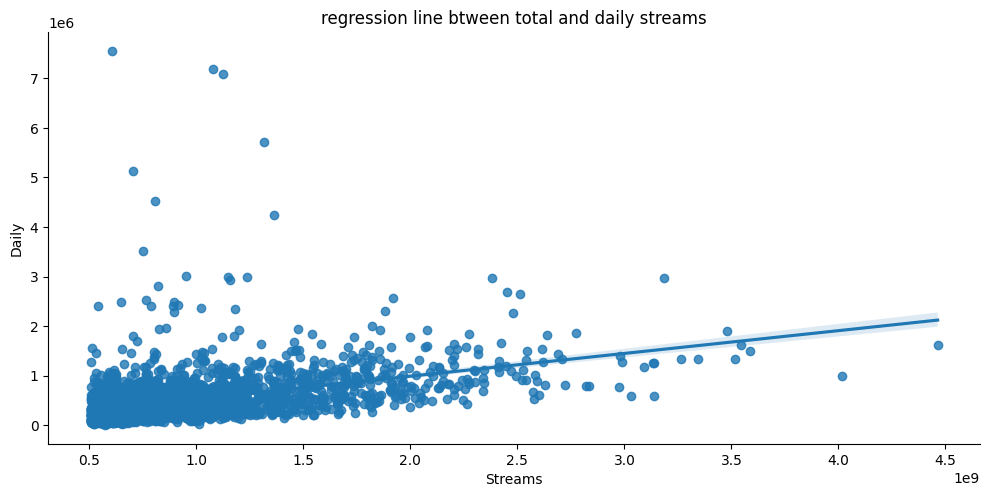

In [69]:
sns.lmplot(data=df,x='Streams',y='Daily',aspect=2)
plt.title('regression line btween total and daily streams')
plt.show()

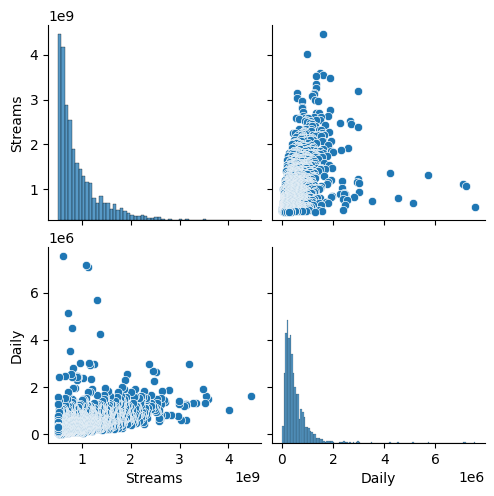

In [70]:
sns.pairplot(df)

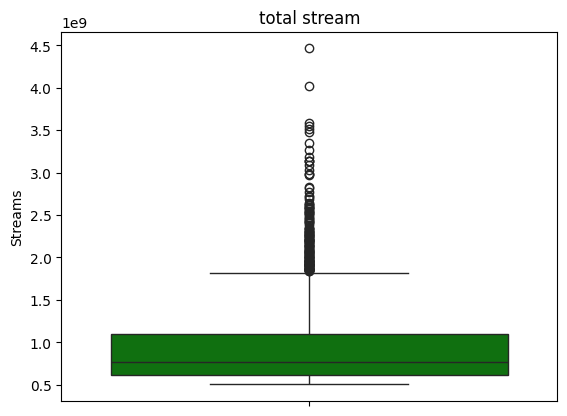

In [71]:
sns.boxplot(df['Streams'],color='green')
plt.title('total stream')
plt.show()

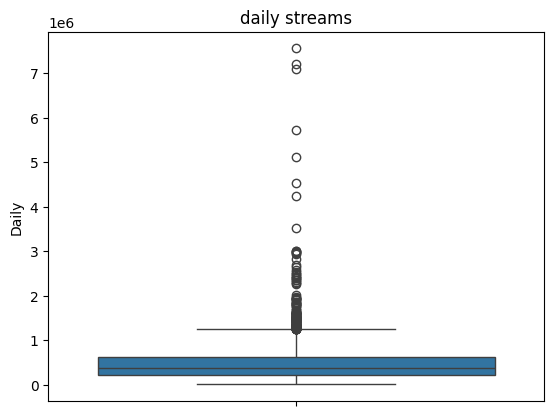

In [72]:
sns.boxplot(df['Daily'])
plt.title('daily streams')
plt.show()

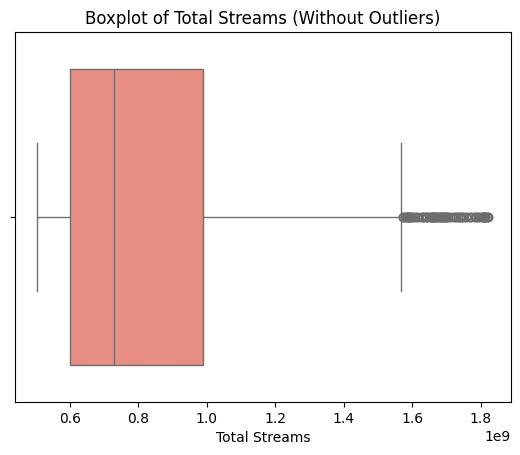

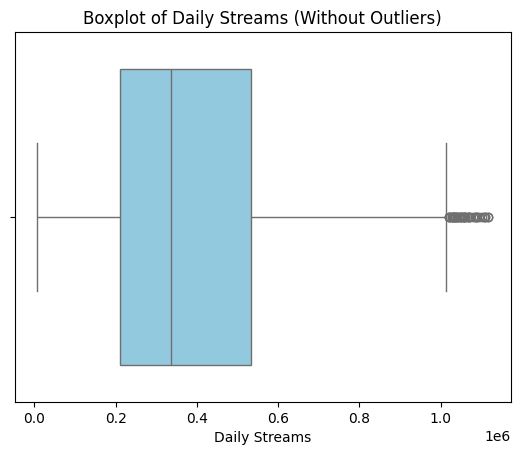

In [75]:
def outlier_remover(df,column):
  Q1=df[column].quantile(.25)
  Q3=df[column].quantile(.75)
  IQR=Q3-Q1
  lower=Q1-1.5*IQR
  upper=Q3+1.5*IQR
  df=df[(df[column]>=lower) & (df[column]<= upper)]
  return df

df=outlier_remover(df,'Streams')
df=outlier_remover(df,'Daily')

sns.boxplot(x=df['Streams'], color='salmon')
plt.title('Boxplot of Total Streams (Without Outliers)')
plt.xlabel('Total Streams')
plt.show()

sns.boxplot(x=df['Daily'], color='skyblue')
plt.title('Boxplot of Daily Streams (Without Outliers)')
plt.xlabel('Daily Streams')
plt.show()

In [77]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
features=df[['Streams','Daily']]
scaled_feature=scaler.fit_transform(features)

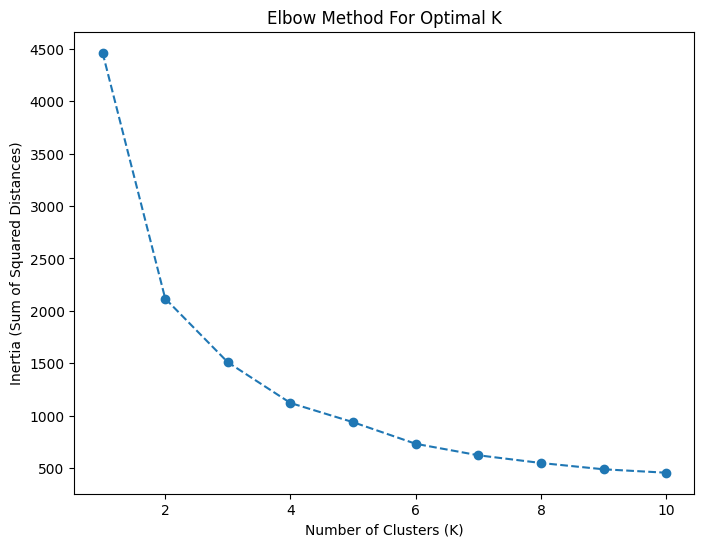

In [82]:
from sklearn.cluster import KMeans
inertia=[]
for i in range(1,11):
  kmeans=KMeans(n_clusters=i,random_state=42)
  kmeans.fit(scaled_feature)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1,11), inertia, marker='o',linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal K')
plt.show()

In [88]:
kmeans=KMeans(n_clusters=4,random_state=42)
cluster=kmeans.fit_predict(scaled_feature)
df['cluster']=cluster
df.head()

,Streams,Daily,Artist,Song,2,0,1,3,cluster
148,1821537537,643292.0,Twenty One Pilots,Ride,2,0,1,3,2
149,1819599508,263131.0,Mariah Carey,All I Want for Christmas Is You,2,0,1,3,0
152,1816755550,361118.0,Sia,Cheap Thrills,2,0,1,3,2
153,1812363965,810500.0,Sia,Chandelier,2,0,1,3,2
154,1811808940,536226.0,The Weeknd,I Feel It Coming,2,0,1,3,2


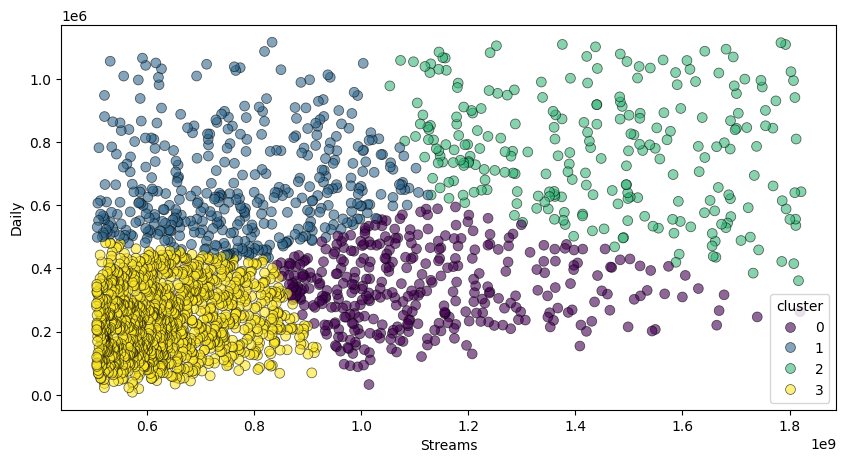

In [97]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df,x='Streams',y='Daily',hue='cluster',palette='viridis',s=50,alpha=.6,edgecolor='black')
plt.show()

In [96]:
cluster_summary=df.groupby('cluster')[['Streams','Daily']].mean().reset_index()
cluster_summary

,cluster,Streams,Daily
0,0,1.109968e+09,340984.652291
1,1,7.715120e+08,657372.473558
2,2,1.439244e+09,769900.928571
3,3,6.411423e+08,241951.531879


In [100]:
cluster_names = {0: 'Moderate Performers',
                 1: 'Trending Songs',
                 2: 'Top Hits',
                 3: 'Less Popular Songs'}

df['Cluster Name'] = df['cluster'].map(cluster_names)

print(df[['cluster', 'Streams', 'Daily', 'Cluster Name']])

      cluster     Streams     Daily         Cluster Name
148         2  1821537537  643292.0             Top Hits
149         0  1819599508  263131.0  Moderate Performers
152         2  1816755550  361118.0             Top Hits
153         2  1812363965  810500.0             Top Hits
154         2  1811808940  536226.0             Top Hits
...       ...         ...       ...                  ...
2494        3   505658549   94261.0   Less Popular Songs
2496        3   505511969  118483.0   Less Popular Songs
2497        3   505386377  205701.0   Less Popular Songs
2498        3   505309100  280336.0   Less Popular Songs
2499        3   505249124  288515.0   Less Popular Songs

[2231 rows x 4 columns]


<ipython-input-103-c43c4f1ae99e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,x='Cluster Name',palette='viridis')


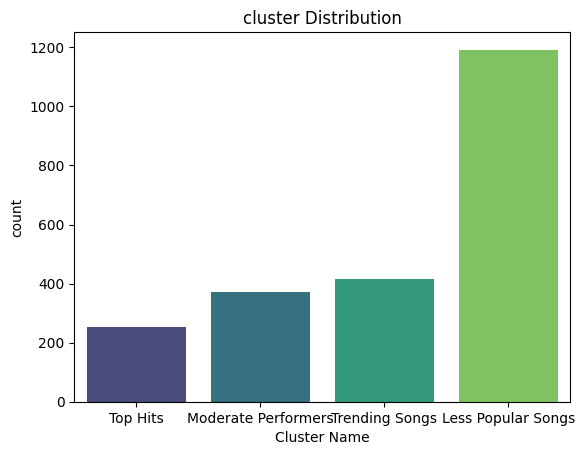

In [103]:
sns.countplot(data=df,x='Cluster Name',palette='viridis')
plt.title('cluster Distribution')
plt.show()

<ipython-input-110-8a4cf715081f>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df,x='Cluster Name',y='Streams',palette='coolwarm')


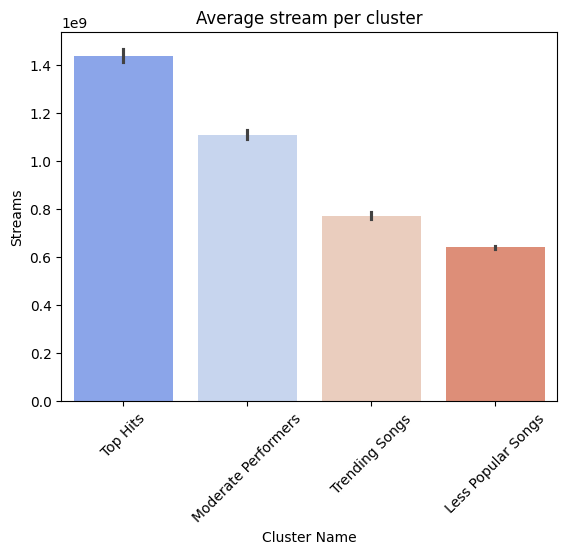

In [110]:
sns.barplot(data=df,x='Cluster Name',y='Streams',palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Average stream per cluster')
plt.show()

<ipython-input-112-7b26c8cfd5d3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df,x='Cluster Name',y='Daily',palette='viridis')


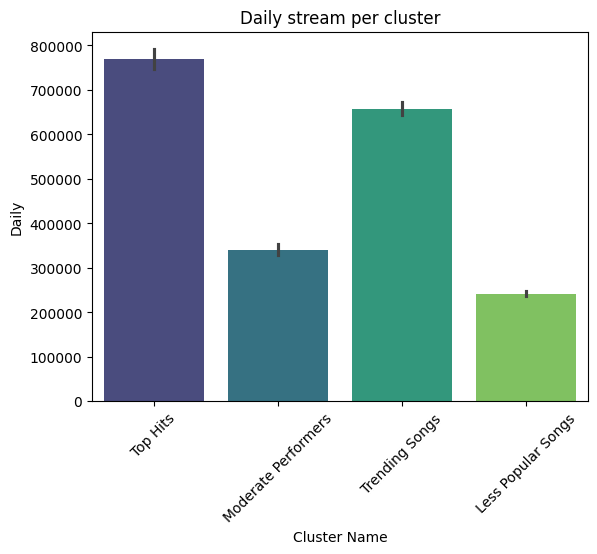

In [112]:
sns.barplot(data=df,x='Cluster Name',y='Daily',palette='viridis')
plt.xticks(rotation=45)
plt.title('Daily stream per cluster')
plt.show()